#Import Libraries

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
import os
import nltk
import torch
import itertools
import datasets
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns 

import random
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from transformers import TFAutoModel, BertConfig, TFBertModel


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Dataset

##Downloading

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d spsayakpaul/arxiv-paper-abstracts

 74% 33.0M/44.6M [00:00<00:00, 99.6MB/s]
100% 44.6M/44.6M [00:00<00:00, 112MB/s] 


In [ ]:
!unzip /content/arxiv-paper-abstracts.zip

Archive:  /content/arxiv-paper-abstracts.zip
  inflating: arxiv_data.csv          
  inflating: arxiv_data_210930-054931.csv  


##Processing 

In [ ]:
df_1 = pd.read_csv('/content/arxiv_data_210930-054931.csv')

In [ ]:
df_1.drop_duplicates('titles',inplace=True)

In [ ]:
def extract_string(str):
    return str[1:-1]

In [ ]:
df_1['terms_'] = df_1['terms'].apply((lambda x: list(map(extract_string,x.strip('][').split(', ')))))

In [ ]:
df_1['num_of_label'] = df_1['terms_'].apply(len)

In [ ]:
y = list(df_1['num_of_label'].value_counts())
x = list(range(1,len(y)+1))

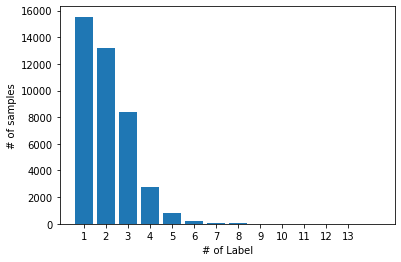

In [ ]:
fig , ax = plt.subplots()
ax.bar(x,y)
ax.set_xlabel('# of Label')
ax.set_ylabel('# of samples')
ax.set_xticks(list(range(1,len(x))))
plt.show()

In [ ]:
labels = df_1['terms_'].to_list()
flatten_list = list(itertools.chain(*labels))
class_count = Counter(flatten_list)
class_count_dic_sorted = dict(sorted(class_count.items(), key=lambda item: item[1],reverse=True))
top_3_class = list(class_count_dic_sorted.keys())[:3]

In [ ]:
top_3_class

['cs.CV', 'cs.LG', 'stat.ML']

In [ ]:
dic_ = {'cs.CV':[],
        'cs.LG':[], 
        'stat.ML':[]}
for _,r in df_1.iterrows():
  list_of_labels = r['terms_']
  list_of_intersection_labels = list(set(list_of_labels) & set(top_3_class))
  list_of_diffrence_labels = list(set(top_3_class) - set(list_of_intersection_labels))
  for item in list_of_intersection_labels:
    dic_[item].append(1)
  for item in list_of_diffrence_labels:
    dic_[item].append(0)

In [ ]:
Counter(dic_['cs.CV'])

Counter({0: 17648, 1: 23457})

In [ ]:
Counter(dic_['cs.LG'])

Counter({0: 17814, 1: 23291})

In [ ]:
Counter(dic_['stat.ML'])

Counter({0: 28004, 1: 13101})

### Using One Input Feature "Abstracts"

In [ ]:
featuers_columns = ['abstracts']

In [ ]:
df_1.reset_index(inplace=True,drop=True)
df_1.drop(columns=df_1.columns[df_1.columns != featuers_columns[0]],inplace = True)

#### Using PorterStemmer (Optional)

In [ ]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [ ]:
def stem_word(w):
  if w not in stop_words:
    return ps.stem(w)
  else:
    return ''

In [ ]:
df_1['abstracts'] = df_1['abstracts'].apply(lambda x: ' '.join(list(map(stem_word,word_tokenize(x)))))

#### Convert to DatasetDict

In [ ]:
df_concat = pd.concat([df_1, pd.DataFrame(dic_)], axis=1)

In [ ]:
df_concat_train,df_concat_validation = train_test_split(df_concat, test_size=0.2, random_state=42)

In [ ]:
df_concat_train.reset_index(inplace=True,drop=True)
df_concat_validation.reset_index(inplace=True,drop=True)

In [ ]:
huggingface_dataset_train = datasets.Dataset.from_pandas(df_concat_train)
huggingface_dataset_validation = datasets.Dataset.from_pandas(df_concat_validation)

In [ ]:
huggingface_dataset_train

In [ ]:
dataset = datasets.DatasetDict()

In [ ]:
dataset['train'] = huggingface_dataset_train
dataset['validation'] = huggingface_dataset_validation

In [ ]:
dataset

In [ ]:
example = dataset['train'][0]

In [ ]:
example

In [ ]:
dataset['train'].features.keys()

In [ ]:
labels = [label for label in dataset['train'].features.keys() if label not in featuers_columns]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

In [ ]:
abstracts_len = df_1['abstracts'].apply((lambda x: len(x.split())))

In [ ]:
MAX_LENGTH = max(abstracts_len)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["abstracts"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

In [ ]:
encoded_dataset.set_format("torch")

### Using Two Input Feauters "Abstracts" and "Titles"

In [ ]:
condition1 = df_1.columns != 'abstracts'
condition2 = df_1.columns != 'titles'

In [ ]:
df_1.reset_index(inplace=True,drop=True)
df_1.drop(columns=df_1.columns[np.logical_and(condition1,condition2)],inplace = True)

In [ ]:
featuers_columns = list(df_1.columns)

#Training

## Using One Input Feature "Abstracts" 

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
batch_size = 8
metric_name = "f1"

In [ ]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [ ]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput([('loss',
                           tensor(0.6469, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)),
                          ('logits',
                           tensor([[ 0.3353,  0.3228, -0.3494]], grad_fn=<AddmmBackward0>))])

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### Results using PorterStemmer

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32884
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20555


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.325500,0.336060,0.851499,0.855091,0.654787
2,0.314500,0.328556,0.854747,0.855701,0.647123
3,0.289800,0.325558,0.857285,0.860188,0.653327
4,0.246700,0.354014,0.846390,0.853336,0.643839


***** Running Evaluation *****
  Num examples = 8221
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-4111
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-4111/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-4111/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-4111/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/checkpoint-4111/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8221
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-8222
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-8222/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-8222/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-8222/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/ch

In [ ]:
text = """
Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations.
"""
text = ' '.join(list(map(stem_word,word_tokenize(text))))

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

### Results without Stemming

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 30000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.314900,0.305184,0.863326,0.873879,0.707159
2,0.295000,0.317291,0.862862,0.873542,0.701666


***** Running Evaluation *****
  Num examples = 11105
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-3750
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-3750/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-3750/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-3750/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/checkpoint-3750/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11105
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-7500
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-7500/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-7500/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.314900,0.305184,0.863326,0.873879,0.707159
2,0.295000,0.317291,0.862862,0.873542,0.701666
3,0.264700,0.330243,0.862609,0.873035,0.694102


***** Running Evaluation *****
  Num examples = 11105
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-11250
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-11250/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-11250/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-11250/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/checkpoint-11250/special_tokens_map.json


## Using Two Input Features "Abtracts" and "titles"

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=True):
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    if double:
    
        input_ids_1, input_masks_1, input_segments_1 = return_id(
            str1, None, 'longest_first', max_sequence_length)

        input_ids_2, input_masks_2, input_segments_2 = return_id(
            str2, None, 'longest_first', max_sequence_length)

        return [input_ids_1, input_masks_1, input_segments_1,
                input_ids_2, input_masks_2, input_segments_2]
    
    else:
        
        input_ids, input_masks, input_segments = return_id(
            str1, str2, 'longest_first', max_sequence_length)

        return [input_ids, input_masks, input_segments,
                None, None, None]        

def compute_input_arrays(df, columns, tokenizer, max_sequence_length, double=True):
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []
    for _, instance in tqdm(df[columns].iterrows(), total=len(df)):
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1, ids_2, masks_2, segments_2 = \
        convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=double)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
    if double:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32),
                np.asarray(input_ids_2, dtype=np.int32), 
                np.asarray(input_masks_2, dtype=np.int32), 
                np.asarray(input_segments_2, dtype=np.int32)]
    
    else:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_1,  pd.DataFrame(dic_).values, 
                                                    random_state=33, test_size = 0.2)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32884, 2) (8221, 2)
(32884, 3) (8221, 3)


In [ ]:
MAX_SEQUENCE_LENGTH = 512

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def compute_input_train_test(mode = 'dual'):
  if mode != 'dual':
    x = False
  else:
    x = True
  input_train = compute_input_arrays(X_train, featuers_columns, tokenizer, MAX_SEQUENCE_LENGTH, double=x)
  input_test = compute_input_arrays(X_test, featuers_columns, tokenizer, MAX_SEQUENCE_LENGTH, double=x)
  return input_train,input_test

In [ ]:
def plot_cs_for_label(map_label,index):
  cnf_matrix = confusion_matrix([map_label for i in y_test.T[index]], 
                              [map_label for i in pred_test[index].flatten()])

  plt.figure(figsize=(7,7))
  plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
  plt.show()

### Concatentate Two Features

In [ ]:
def simple_bert(type_):
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding = bert_model(id_, attention_mask=mask_, token_type_ids=atn_)[0]
    if type_ == 'GlobalAveragePooling1D':
      x = GlobalAveragePooling1D()(embedding)
    elif type_ == 'Flatten':
      x = Flatten()(embedding) 
    x = Dropout(0.2)(x)
    out_CV = Dense(1, activation='sigmoid',name = 'out_CV')(x)
    out_LG = Dense(1, activation='sigmoid',name = 'out_LG')(x)
    out_ML = Dense(1, activation='sigmoid',name = 'out_ML')(x)

    model = Model(inputs=[id_, mask_, atn_], outputs=[out_CV,out_LG,out_ML])
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.compile(optimizer=opt,
                  loss={'out_CV': 'binary_crossentropy', 'out_LG': 'binary_crossentropy'
                        ,'out_ML':'binary_crossentropy'},
                  metrics={'out_CV': tf.keras.metrics.Accuracy(),
                          'out_LG': tf.keras.metrics.Accuracy(),
                          'out_ML': tf.keras.metrics.Accuracy()})
    
    return model

In [ ]:
input_train,input_test = compute_input_train_test('single')

####using GlobalAveragePooling1D

In [ ]:
model = simple_bert('GlobalAveragePooling1D')

In [ ]:
model.fit(input_train, y = (y_train.T[0],y_train.T[1],y_train.T[2]), epochs=5, batch_size=6)

Epoch 1/5
5481/5481 [==============================] - 4178s 758ms/step - loss: 0.9958 - out_CV_loss: 0.2073 - out_LG_loss: 0.3669 - out_ML_loss: 0.4217 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 2/5
5481/5481 [==============================] - 4157s 758ms/step - loss: 0.8620 - out_CV_loss: 0.1554 - out_LG_loss: 0.3198 - out_ML_loss: 0.3868 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 3/5
5481/5481 [==============================] - 4158s 759ms/step - loss: 0.7565 - out_CV_loss: 0.1164 - out_LG_loss: 0.2850 - out_ML_loss: 0.3551 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 4/5
5481/5481 [==============================] - 4159s 759ms/step - loss: 0.6459 - out_CV_loss: 0.0860 - out_LG_loss: 0.2453 - out_ML_loss: 0.3146 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 5/5
5481/5481 [=======

##### Confusion Matrix

In [ ]:
pred_test = np.round(model.predict(input_test))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3505
           1       0.94      0.94      0.94      4716

    accuracy                           0.93      8221
   macro avg       0.93      0.93      0.93      8221
weighted avg       0.93      0.93      0.93      8221



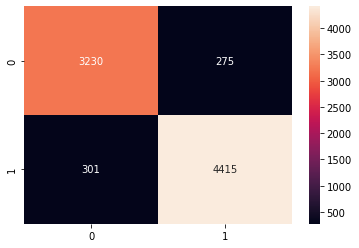

In [ ]:
print(classification_report(y_test.T[0], pred_test[0].flatten()))
sns.heatmap(confusion_matrix(y_test.T[0],pred_test[0].flatten()), annot=True,fmt='g')

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3561
           1       0.86      0.86      0.86      4660

    accuracy                           0.84      8221
   macro avg       0.84      0.84      0.84      8221
weighted avg       0.84      0.84      0.84      8221



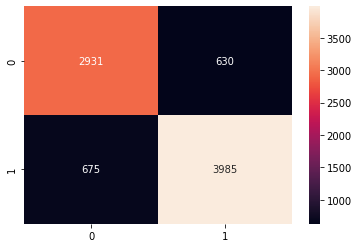

In [ ]:
print(classification_report(y_test.T[1], pred_test[1].flatten()))
sns.heatmap(confusion_matrix(y_test.T[1],pred_test[1].flatten()), annot=True,fmt='g')

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      5587
           1       0.70      0.61      0.65      2634

    accuracy                           0.79      8221
   macro avg       0.76      0.74      0.75      8221
weighted avg       0.78      0.79      0.79      8221



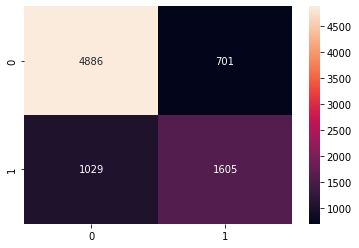

In [ ]:
print(classification_report(y_test.T[2], pred_test[2].flatten()))
sns.heatmap(confusion_matrix(y_test.T[2],pred_test[2].flatten()), annot=True,fmt='g')

####using Flatten

In [ ]:
model = simple_bert('Flatten')

In [ ]:
model.fit(input_train, y = (y_train.T[0],y_train.T[1],y_train.T[2]), epochs=5, batch_size=6)

Epoch 1/5
5481/5481 [==============================] - 4349s 790ms/step - loss: 1.0372 - out_CV_loss: 0.2193 - out_LG_loss: 0.3818 - out_ML_loss: 0.4361 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 2/5
5481/5481 [==============================] - 4331s 790ms/step - loss: 0.8009 - out_CV_loss: 0.1437 - out_LG_loss: 0.3002 - out_ML_loss: 0.3570 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 3/5
5481/5481 [==============================] - 4332s 790ms/step - loss: 0.3678 - out_CV_loss: 0.0493 - out_LG_loss: 0.1400 - out_ML_loss: 0.1785 - out_CV_accuracy: 0.0000e+00 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 4/5
5481/5481 [==============================] - 4336s 791ms/step - loss: 0.1410 - out_CV_loss: 0.0201 - out_LG_loss: 0.0526 - out_ML_loss: 0.0683 - out_CV_accuracy: 0.0016 - out_LG_accuracy: 0.0000e+00 - out_ML_accuracy: 0.0000e+00
Epoch 5/5
5481/5481 [===========

###### Confusion Matrix 

In [ ]:
pred_test = np.round(model.predict(input_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3505
           1       0.96      0.92      0.94      4716

    accuracy                           0.93      8221
   macro avg       0.93      0.93      0.93      8221
weighted avg       0.93      0.93      0.93      8221



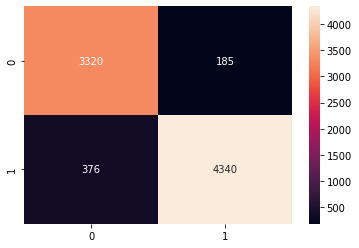

In [ ]:
print(classification_report(y_test.T[0], pred_test[0].flatten()))
sns.heatmap(confusion_matrix(y_test.T[0],pred_test[0].flatten()), annot=True,fmt='g')

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3561
           1       0.86      0.85      0.86      4660

    accuracy                           0.84      8221
   macro avg       0.83      0.83      0.83      8221
weighted avg       0.84      0.84      0.84      8221



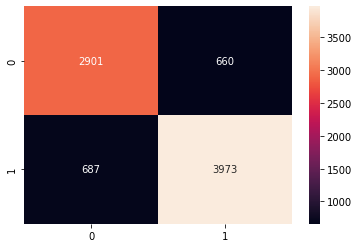

In [ ]:
print(classification_report(y_test.T[1], pred_test[1].flatten()))
sns.heatmap(confusion_matrix(y_test.T[1],pred_test[1].flatten()), annot=True,fmt='g')

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      5587
           1       0.64      0.75      0.69      2634

    accuracy                           0.78      8221
   macro avg       0.75      0.77      0.76      8221
weighted avg       0.80      0.78      0.79      8221



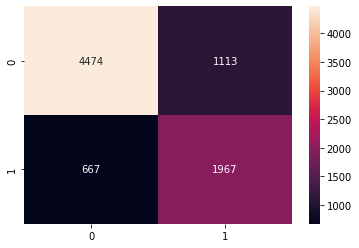

In [ ]:
print(classification_report(y_test.T[2], pred_test[2].flatten()))
sns.heatmap(confusion_matrix(y_test.T[2],pred_test[2].flatten()), annot=True,fmt='g')

### Multiple Inputs

In [ ]:
def dual_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    id2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    mask1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    atn1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model1 = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    bert_model2 = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding1 = bert_model1(id1, attention_mask=mask1, token_type_ids=atn1)[0]
    embedding2 = bert_model2(id2, attention_mask=mask2, token_type_ids=atn2)[0]
    
    x1 = GlobalAveragePooling1D()(embedding1)
    x2 = GlobalAveragePooling1D()(embedding2)
    
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out_CV = Dense(1, activation='sigmoid',name = 'out_CV')(x)
    out_LG = Dense(1, activation='sigmoid',name = 'out_LG')(x)
    out_ML = Dense(1, activation='sigmoid',name = 'out_ML')(x)

    model = Model(inputs=[id1, mask1, atn1, id2, mask2, atn2], outputs=[out_CV,out_LG,out_ML])
    model.compile(optimizer=opt,
                  loss={'out_CV': 'binary_crossentropy', 'out_LG': 'binary_crossentropy'
                        ,'out_ML':'binary_crossentropy'},
                  metrics={'out_CV': tf.keras.metrics.Accuracy(),
                          'out_LG': tf.keras.metrics.Accuracy(),
                          'out_ML': tf.keras.metrics.Accuracy()})
    
    return model

In [ ]:
input_train,input_test = compute_input_train_test()

  0%|          | 0/36994 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/4111 [00:00<?, ?it/s]

In [ ]:
model = dual_bert()
model.fit(input_test, y = (y_test.T[0],y_test.T[1],y_test.T[2]), epochs=1, batch_size=6)